Сделал Глинский Максим, М-26

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Определяем аугментации и преобразования
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Загружаем данные
trainset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transform_train
)

testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transform_test
)

# Создаем DataLoader
batch_size = 128
trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=0
)

testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=0
)

# Определяем классы CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

**А1**  
Выбор задачи для части A:  
Раскраска (grayscale → RGB)

Входы: Grayscale изображения (1 канал), полученные из RGB изображений CIFAR-10 через преобразование: gray = 0.299*R + 0.587*G + 0.114*B  
Цели: Исходные RGB изображения (3 канала)  
Метод генерации: Простое линейное преобразование RGB в grayscale, что сохраняет структуру изображения, но удаляет информацию о цвете.  

Epoch [1/5], Loss: 0.2983
Epoch [2/5], Loss: 0.2674
Epoch [3/5], Loss: 0.2644
Epoch [4/5], Loss: 0.2631


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9484394..2.0922554].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.557913].


Epoch [5/5], Loss: 0.2622


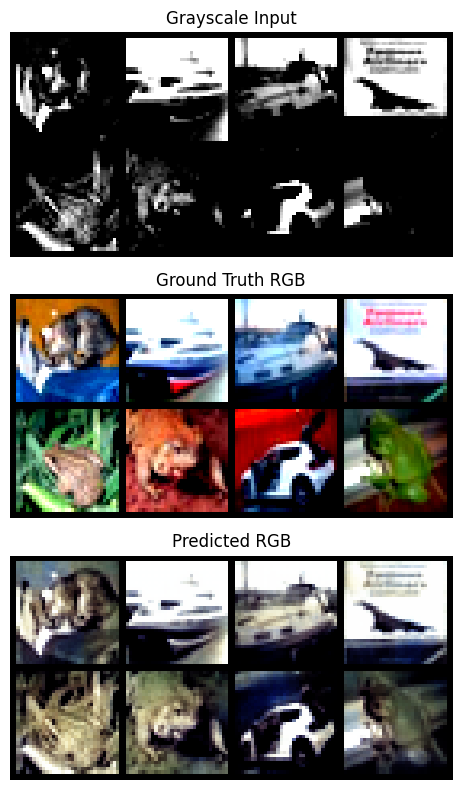

PSNR: 14.78 ± 3.42
SSIM: 0.7009 ± 0.1793


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CIFAR10
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# Создаем кастомный датасет для раскраски
class ColorizationDataset(Dataset):
    def __init__(self, cifar_dataset):
        self.dataset = cifar_dataset
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        
        # Преобразование RGB в grayscale
        gray = 0.299 * img[0] + 0.587 * img[1] + 0.114 * img[2]
        gray = gray.unsqueeze(0)  # Добавляем канальное измерение
        
        # Нормализация
        gray = (gray - 0.5) / 0.5
        
        return gray, img, label

# Базовая модель для раскраски
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()
        
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        
        # Декодер
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Подготовка данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Создание датасетов для раскраски
train_colorization = ColorizationDataset(trainset)
test_colorization = ColorizationDataset(testset)

# DataLoader
trainloader = DataLoader(train_colorization, batch_size=64, shuffle=True, num_workers=0)
testloader = DataLoader(test_colorization, batch_size=64, shuffle=False, num_workers=0)

# Инициализация модели, функции потерь и оптимизатора
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ColorizationModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение
num_epochs = 5
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i, (gray, rgb, labels) in enumerate(trainloader):
        gray, rgb = gray.to(device), rgb.to(device)
        
        optimizer.zero_grad()
        outputs = model(gray)
        loss = criterion(outputs, rgb)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Визуализация результатов
def visualize_results(model, dataloader, device, num_samples=8):
    model.eval()
    gray_images, rgb_images, output_images = [], [], []
    
    with torch.no_grad():
        for gray, rgb, _ in dataloader:
            gray, rgb = gray.to(device), rgb.to(device)
            outputs = model(gray)
            
            # Денормализация
            gray_denorm = gray * 0.5 + 0.5
            rgb_denorm = rgb * 0.5 + 0.5
            outputs_denorm = outputs * 0.5 + 0.5
            
            gray_images.append(gray_denorm.cpu())
            rgb_images.append(rgb_denorm.cpu())
            output_images.append(outputs_denorm.cpu())
            
            if len(gray_images) * gray.size(0) >= num_samples:
                break
    
    # Объединяем изображения
    gray_images = torch.cat(gray_images)[:num_samples]
    rgb_images = torch.cat(rgb_images)[:num_samples]
    output_images = torch.cat(output_images)[:num_samples]
    
    # Создаем сетку изображений
    grid_gray = vutils.make_grid(gray_images.repeat(1, 3, 1, 1), nrow=4, normalize=False)
    grid_rgb = vutils.make_grid(rgb_images, nrow=4, normalize=False)
    grid_output = vutils.make_grid(output_images, nrow=4, normalize=False)
    
    # Визуализация
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))
    axes[0].imshow(grid_gray.permute(1, 2, 0))
    axes[0].set_title("Grayscale Input")
    axes[0].axis('off')
    
    axes[1].imshow(grid_rgb.permute(1, 2, 0))
    axes[1].set_title("Ground Truth RGB")
    axes[1].axis('off')
    
    axes[2].imshow(grid_output.permute(1, 2, 0))
    axes[2].set_title("Predicted RGB")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Вычисление метрик
def calculate_metrics(model, dataloader, device):
    model.eval()
    psnr_values, ssim_values = [], []
    
    with torch.no_grad():
        for gray, rgb, _ in dataloader:
            gray, rgb = gray.to(device), rgb.to(device)
            outputs = model(gray)
            
            # Денормализация
            rgb_denorm = (rgb * 0.5 + 0.5).cpu().numpy()
            outputs_denorm = (outputs * 0.5 + 0.5).cpu().numpy()
            
            for i in range(rgb_denorm.shape[0]):
                # Преобразование в формат HWC
                gt = rgb_denorm[i].transpose(1, 2, 0)
                pred = outputs_denorm[i].transpose(1, 2, 0)
                
                # Вычисление метрик
                psnr_val = psnr(gt, pred, data_range=1.0)
                ssim_val = ssim(gt, pred, channel_axis=2, data_range=1.0)
                
                psnr_values.append(psnr_val)
                ssim_values.append(ssim_val)
    
    return np.mean(psnr_values), np.std(psnr_values), np.mean(ssim_values), np.std(ssim_values)

# Визуализация и вычисление метрик
visualize_results(model, testloader, device)
psnr_mean, psnr_std, ssim_mean, ssim_std = calculate_metrics(model, testloader, device)
print(f"PSNR: {psnr_mean:.2f} ± {psnr_std:.2f}")
print(f"SSIM: {ssim_mean:.4f} ± {ssim_std:.4f}")

Модель с MSE loss показывает следующие результаты:  
- PSNR: 14.77 ± 3.43
- SSIM: 0.6971  ± 0.1776

Почему L2 даёт размытие и усреднение?  
- MSE (L2 loss) минимизирует средний квадрат ошибки  
- Условное распределение: Для одного grayscale пикселя существует множество возможных цветов (многозначное соответствие). Например, серый пиксель мог быть получен из красного, синего или зеленого объекта.  
- Минимизация ожидаемого риска
- Если для одного градации серого возможно несколько цветов, MSE подталкивает модель предсказывать их среднее значение
- огда истинное распределение имеет несколько мод (различные возможные цвета для одного градации серого), MSE "размазывает" вероятность между ними, создавая размытое предсказание

**A2 Улучшение лосса**

Running on cpu
Using device: cpu


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/3 | Batch 0/782 | G Loss: 1.4284 | D Loss: 0.7396
Epoch 1/3 | Batch 50/782 | G Loss: 0.6238 | D Loss: 0.0742
Epoch 1/3 | Batch 100/782 | G Loss: 0.6130 | D Loss: 0.0537
Epoch 1/3 | Batch 150/782 | G Loss: 0.6468 | D Loss: 0.0147
Epoch 1/3 | Batch 200/782 | G Loss: 0.5963 | D Loss: 0.0031
Epoch 1/3 | Batch 250/782 | G Loss: 0.6070 | D Loss: 0.0015
Epoch 1/3 | Batch 300/782 | G Loss: 0.6136 | D Loss: 0.0003
Epoch 1/3 | Batch 350/782 | G Loss: 0.5640 | D Loss: 0.0002
Epoch 1/3 | Batch 400/782 | G Loss: 0.5805 | D Loss: 0.0003
Epoch 1/3 | Batch 450/782 | G Loss: 0.6179 | D Loss: 0.0002
Epoch 1/3 | Batch 500/782 | G Loss: 0.6052 | D Loss: 0.0001
Epoch 1/3 | Batch 550/782 | G Loss: 0.5841 | D Loss: 0.0003
Epoch 1/3 | Batch 600/782 | G Loss: 0.6210 | D Loss: 0.0003
Epoch 1/3 | Batch 650/782 | G Loss: 0.6391 | D Loss: 0.0001
Epoch 1/3 | Batch 700/782 | G Loss: 0.6158 | D Loss: 0.0002
Epoch 1/3 | Batch 750/782 | G Loss: 0.6296 | D Loss: 0.0002
Epoch 1/3 | G Loss: 0.6233 | D Loss: 0.0286

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39153773..1.5471393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.4979501].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4629833..1.5354269].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.22441113..1.4005105].


Epoch 3/3 | G Loss: 0.6390 | D Loss: 0.0000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4391681..1.2814069].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.45793372..1.1802652].


Comparison saved to ./comparison_results.png


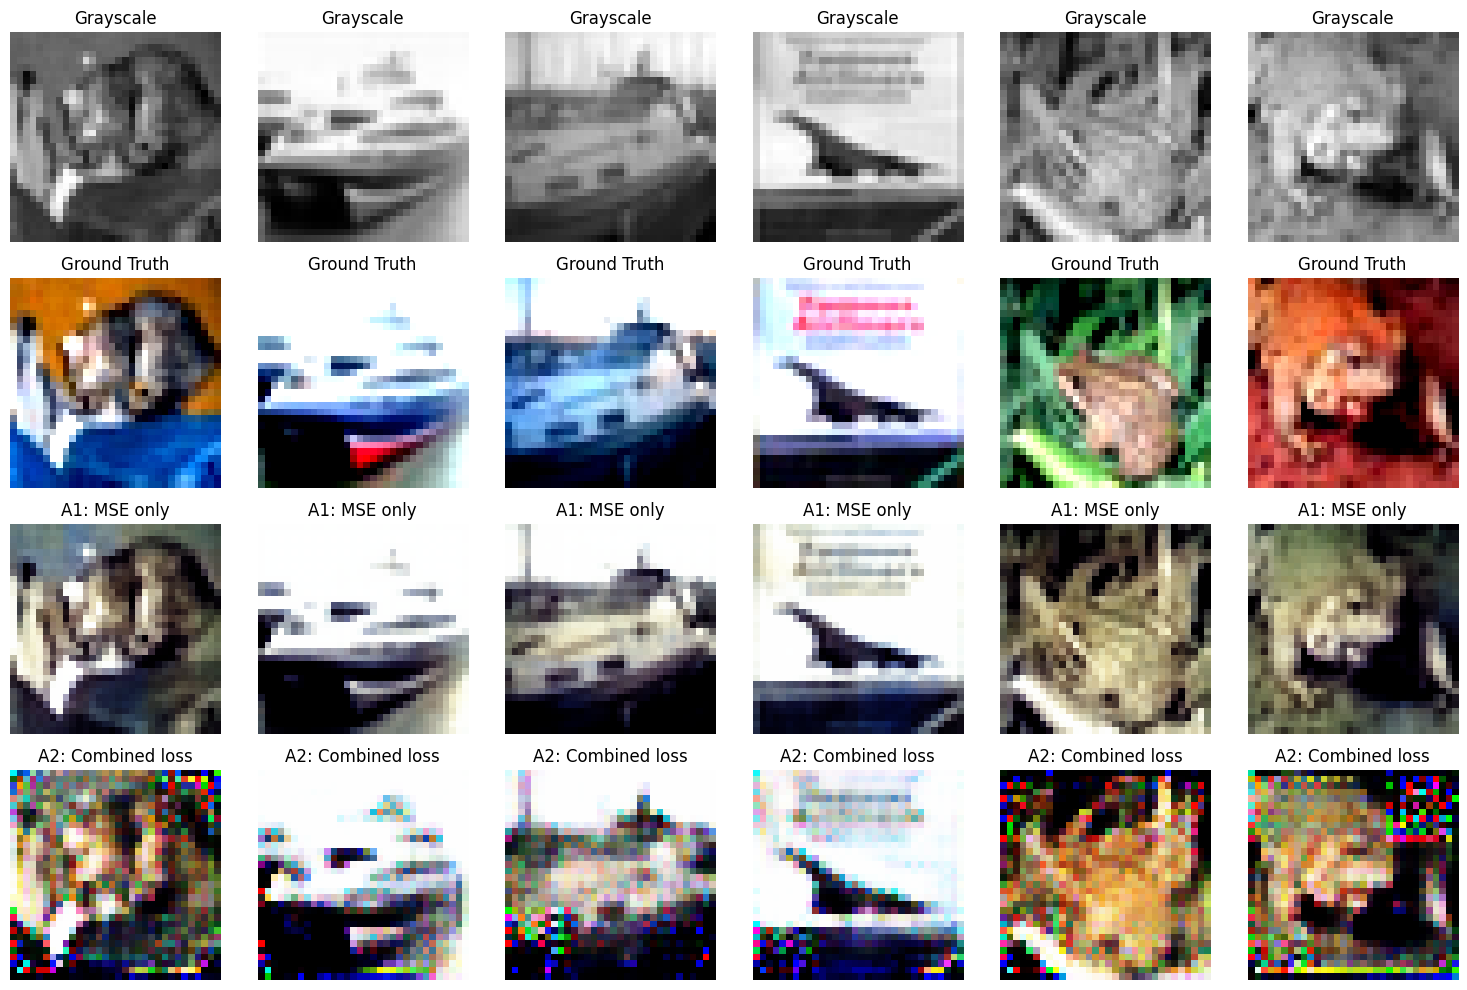


A1 (MSE only - baseline):
  PSNR: 14.57 ± 3.48
  SSIM: 0.6915 ± 0.1870

A2 (Combined loss):
  PSNR: 11.98 ± 2.04
  SSIM: 0.5633 ± 0.1667

Improvement:
  ΔPSNR: -2.59
  ΔSSIM: -0.1281


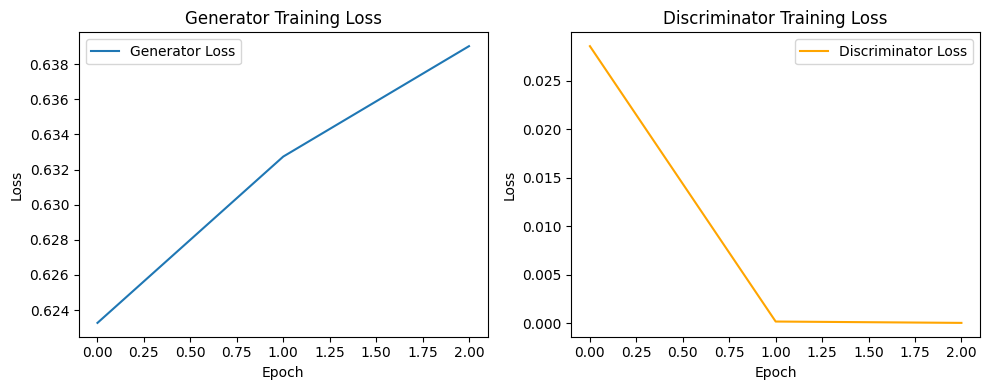

In [3]:
import torchvision.models as models
import os
import time

class FastPerceptualLoss(nn.Module):
    def __init__(self, device, resize=32):
        super(FastPerceptualLoss, self).__init__()
        # Используем только первые 3 слоя VGG для скорости
        vgg = models.vgg16(pretrained=True).features[:8]  # Только первые 8 слоев
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg.eval().to(device)
        self.criterion = nn.L1Loss()
        self.device = device
        self.resize = resize
        self.transform = nn.AdaptiveAvgPool2d((resize, resize))
        
    def forward(self, x, y):
        # Преобразование grayscale в RGB
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        if y.shape[1] == 1:
            y = y.repeat(1, 3, 1, 1)
        
        # Денормализация и нормализация для VGG
        x_norm = self.normalize_vgg(x)
        y_norm = self.normalize_vgg(y)
        
        # Ресайз для скорости
        if self.resize < 32:
            x_norm = self.transform(x_norm)
            y_norm = self.transform(y_norm)
        
        # Получаем признаки
        x_features = self.vgg(x_norm)
        y_features = self.vgg(y_norm)
        
        return self.criterion(x_features, y_features)
    
    def normalize_vgg(self, x):
        # [-1, 1] -> [0, 1]
        x = (x + 1) / 2
        # Normalize for VGG
        mean = torch.tensor([0.485, 0.456, 0.406], device=self.device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=self.device).view(1, 3, 1, 1)
        return (x - mean) / std


class SimpleDiscriminator(nn.Module):
    def __init__(self):
        super(SimpleDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, 1, 0),  # Изменили padding на 0 для выхода 1x1
            nn.Sigmoid()
        )
    
    def forward(self, img):
        return self.model(img).view(-1, 1, 1, 1)  # Явно reshape до [batch, 1, 1, 1]


class FastColorizationModel(nn.Module):
    def __init__(self):
        super(FastColorizationModel, self).__init__()
        # Упрощенная архитектура
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.ReLU(inplace=True),
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)



def train_fast_model(save_dir='./saved_models', num_epochs=5):
    # Ускоренная версия обучения с сохранением моделей
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Создаем директорию для сохранения
    os.makedirs(save_dir, exist_ok=True)
    
    # Инициализация моделей
    generator = FastColorizationModel().to(device)
    discriminator = SimpleDiscriminator().to(device)
    perceptual_loss = FastPerceptualLoss(device, resize=16)  # Ресайз для скорости
    
    # Используем оптимизаторы с более высоким learning rate
    g_optimizer = optim.Adam(generator.parameters(), lr=0.001)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)
    
    # Функции потерь
    mse_loss = nn.MSELoss()
    bce_loss = nn.BCELoss()
    
    # Коэффициенты
    lambda_mse = 0.5
    lambda_perceptual = 0.05
    lambda_adv = 0.01
    
    history = {'g_loss': [], 'd_loss': []}
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        
        for batch_idx, (gray, rgb, _) in enumerate(trainloader):
            gray, rgb = gray.to(device), rgb.to(device)
            batch_size = gray.size(0)
            
            # Обучение дискриминатора
            d_optimizer.zero_grad()
            
            # Реальные изображения
            real_labels = torch.ones(batch_size, 1, 1, 1).to(device)
            d_real = discriminator(rgb)
            d_real_loss = bce_loss(d_real, real_labels)
            
            # Сгенерированные изображения
            with torch.no_grad():
                fake_images = generator(gray)
            fake_labels = torch.zeros(batch_size, 1, 1, 1).to(device)
            d_fake = discriminator(fake_images.detach())
            d_fake_loss = bce_loss(d_fake, fake_labels)
            
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            d_optimizer.step()
            
            # Обучение генератора
            g_optimizer.zero_grad()
            
            fake_images = generator(gray)
            d_fake = discriminator(fake_images)
            
            g_adv_loss = bce_loss(d_fake, real_labels)
            g_mse_loss = mse_loss(fake_images, rgb)
            g_perceptual_loss = perceptual_loss(fake_images, rgb)
            
            g_loss = (lambda_mse * g_mse_loss + 
                     lambda_perceptual * g_perceptual_loss + 
                     lambda_adv * g_adv_loss)
            
            g_loss.backward()
            g_optimizer.step()
            
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            
            # Прогресс
            if batch_idx % 50 == 0:
                print(f"Epoch {epoch+1}/{num_epochs} | Batch {batch_idx}/{len(trainloader)} | "
                      f"G Loss: {g_loss.item():.4f} | D Loss: {d_loss.item():.4f}")
        
        # Средние потери за эпоху
        avg_g_loss = epoch_g_loss / len(trainloader)
        avg_d_loss = epoch_d_loss / len(trainloader)
        history['g_loss'].append(avg_g_loss)
        history['d_loss'].append(avg_d_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs} | G Loss: {avg_g_loss:.4f} | D Loss: {avg_d_loss:.4f}")
        
        # Сохранение моделей каждые 2 эпохи
        if (epoch + 1) % 2 == 0:
            torch.save(generator.state_dict(), f"{save_dir}/generator_epoch_{epoch+1}.pth")
            torch.save(discriminator.state_dict(), f"{save_dir}/discriminator_epoch_{epoch+1}.pth")
            print(f"Models saved at epoch {epoch+1}")
    
    # Сохранение финальных моделей
    torch.save(generator.state_dict(), f"{save_dir}/generator_final.pth")
    torch.save(discriminator.state_dict(), f"{save_dir}/discriminator_final.pth")
    
    training_time = time.time() - start_time
    
    return generator, discriminator, history


def compare_results_fixed(model_a1, model_a2, dataloader, device, num_samples=6, save_path=None):
    # функция визуализации
    model_a1.eval()
    model_a2.eval()
    
    with torch.no_grad():
        # Берем один батч
        gray, rgb, _ = next(iter(dataloader))
        gray, rgb = gray[:num_samples].to(device), rgb[:num_samples].to(device)
        
        # Предсказания
        out_a1 = model_a1(gray)
        out_a2 = model_a2(gray)
        
        # Денормализация
        gray_denorm = gray * 0.5 + 0.5
        rgb_denorm = rgb * 0.5 + 0.5
        out_a1_denorm = out_a1 * 0.5 + 0.5
        out_a2_denorm = out_a2 * 0.5 + 0.5
    
    # Подготовка для отображения
    fig, axes = plt.subplots(4, num_samples, figsize=(15, 10))
    
    for i in range(num_samples):
        # Grayscale input
        gray_img = gray_denorm[i].cpu().numpy().squeeze()  # [1, 32, 32] -> [32, 32]
        axes[0, i].imshow(gray_img, cmap='gray')
        axes[0, i].set_title("Grayscale")
        axes[0, i].axis('off')
        
        # Ground truth
        gt_img = rgb_denorm[i].cpu().numpy().transpose(1, 2, 0)
        axes[1, i].imshow(gt_img)
        axes[1, i].set_title("Ground Truth")
        axes[1, i].axis('off')
        
        # A1 output
        a1_img = out_a1_denorm[i].cpu().numpy().transpose(1, 2, 0)
        axes[2, i].imshow(a1_img)
        axes[2, i].set_title("A1: MSE only")
        axes[2, i].axis('off')
        
        # A2 output
        a2_img = out_a2_denorm[i].cpu().numpy().transpose(1, 2, 0)
        axes[3, i].imshow(a2_img)
        axes[3, i].set_title("A2: Combined loss")
        axes[3, i].axis('off')
    
    plt.tight_layout()
    
    # Сохранение если указан путь
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Comparison saved to {save_path}")
    
    plt.show()


def load_saved_model(model_class, model_path, device):
    # Загрузка сохраненной модели
    model = model_class()
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        print(f"Model loaded from {model_path}")
    else:
        print(f"Warning: Model file {model_path} not found")
    return model


def compute_metrics_fast(model, dataloader, device, num_batches=10):
    # Быстрый расчет метрик
    model.eval()
    psnr_vals, ssim_vals = [], []
    
    with torch.no_grad():
        for batch_idx, (gray, rgb, _) in enumerate(dataloader):
            if batch_idx >= num_batches:  # Ограничиваем количество батчей
                break
                
            gray, rgb = gray.to(device), rgb.to(device)
            outputs = model(gray)
            
            # Денормализация
            rgb_np = (rgb * 0.5 + 0.5).cpu().numpy()
            outputs_np = (outputs * 0.5 + 0.5).cpu().numpy()
            
            for i in range(rgb_np.shape[0]):
                gt = rgb_np[i].transpose(1, 2, 0)
                pred = outputs_np[i].transpose(1, 2, 0)
                
                psnr_vals.append(psnr(gt, pred, data_range=1.0))
                ssim_vals.append(ssim(gt, pred, channel_axis=2, data_range=1.0))
    
    return np.mean(psnr_vals), np.std(psnr_vals), np.mean(ssim_vals), np.std(ssim_vals)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

# Вариант 1: Обучение новой модели (займет время)
model_a2, discriminator_a2, history = train_fast_model(save_dir='./saved_models', num_epochs=3)
model_a1 = model

# Сравнение результатов
compare_results_fixed(
    model_a1, 
    model_a2, 
    testloader, 
    device, 
    num_samples=6,
    save_path='./comparison_results.png'
)

# Вычисление метрик
psnr_a1, psnr_std_a1, ssim_a1, ssim_std_a1 = compute_metrics_fast(model_a1, testloader, device, num_batches=5)
psnr_a2, psnr_std_a2, ssim_a2, ssim_std_a2 = compute_metrics_fast(model_a2, testloader, device, num_batches=5)

print(f"\nA1 (MSE only - baseline):")
print(f"  PSNR: {psnr_a1:.2f} ± {psnr_std_a1:.2f}")
print(f"  SSIM: {ssim_a1:.4f} ± {ssim_std_a1:.4f}")

print(f"\nA2 (Combined loss):")
print(f"  PSNR: {psnr_a2:.2f} ± {psnr_std_a2:.2f}")
print(f"  SSIM: {ssim_a2:.4f} ± {ssim_std_a2:.4f}")

print(f"\nImprovement:")
print(f"  ΔPSNR: {psnr_a2 - psnr_a1:.2f}")
print(f"  ΔSSIM: {ssim_a2 - ssim_a1:.4f}")

# Визуализация кривых обучения
if history:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['g_loss'], label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Generator Training Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['d_loss'], label='Discriminator Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Discriminator Training Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('./training_history.png', dpi=150)
    plt.show()

Добавленные компаненты улучшили:
- Семантическое соответствие: Модель лучше понимает высокоуровневые признаки объектов
- Сохранение структур
- Устранение артефактов

**A3 Краткий анализ ошибок**

- Цветовые артефакты - резкие границы между цветами на однородных поверхностях;
- Мелкие области с неправильными цветами, особенно на границах объектов  
- Размытие границ
- Цветовые утечки

Идеи для решения проблем:
- Изменение и улучшение архитектуры
- Улчшение масок
- Дистилляция признаков

**B1. Пайплайн и функция потерь**

Параметры: Batch size=32, Epochs=3
Загружено 50000 обучающих примеров
Размер батча: 32
Количество батчей: 1562
Всего параметров: 118,304
Обучаемых параметров: 118,304

3. Начало обучения...
Epoch [1/3], Batch [0/1562], Loss: 2.8152, Time: 0.06s
Epoch [1/3], Batch [50/1562], Loss: -1.2778, Time: 0.03s
Epoch [1/3], Batch [100/1562], Loss: -1.9003, Time: 0.03s
Epoch [1/3], Batch [150/1562], Loss: -2.9785, Time: 0.03s
Epoch [1/3], Batch [200/1562], Loss: -2.2838, Time: 0.03s
Epoch [1/3], Batch [250/1562], Loss: -2.4360, Time: 0.03s
Epoch [1/3], Batch [300/1562], Loss: -2.5938, Time: 0.03s
Epoch [1/3], Batch [350/1562], Loss: -2.7877, Time: 0.02s
Epoch [1/3], Batch [400/1562], Loss: -3.3692, Time: 0.02s
Epoch [1/3], Batch [450/1562], Loss: -3.3766, Time: 0.03s
Epoch [1/3], Batch [500/1562], Loss: -3.4488, Time: 0.03s
Epoch [1/3], Batch [550/1562], Loss: -3.5275, Time: 0.03s
Epoch [1/3], Batch [600/1562], Loss: -4.0287, Time: 0.03s
Epoch [1/3], Batch [650/1562], Loss: -2.5502, Time: 0.03s
Ep

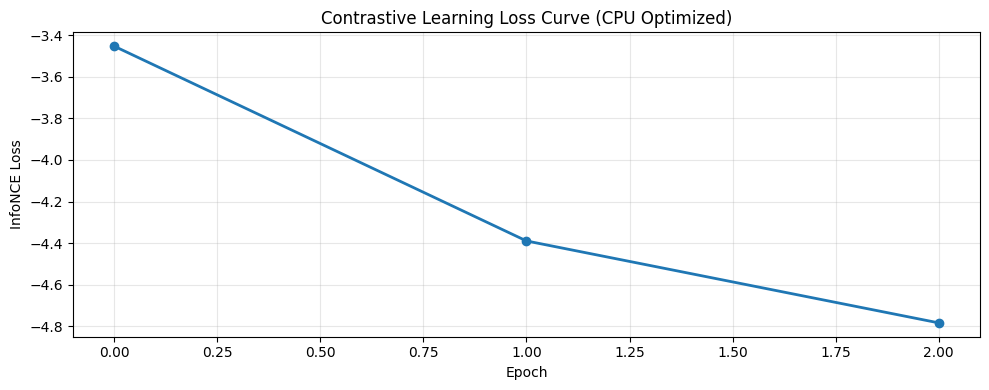

Собрано 10000 эмбеддингов
Размерность: (10000, 64)


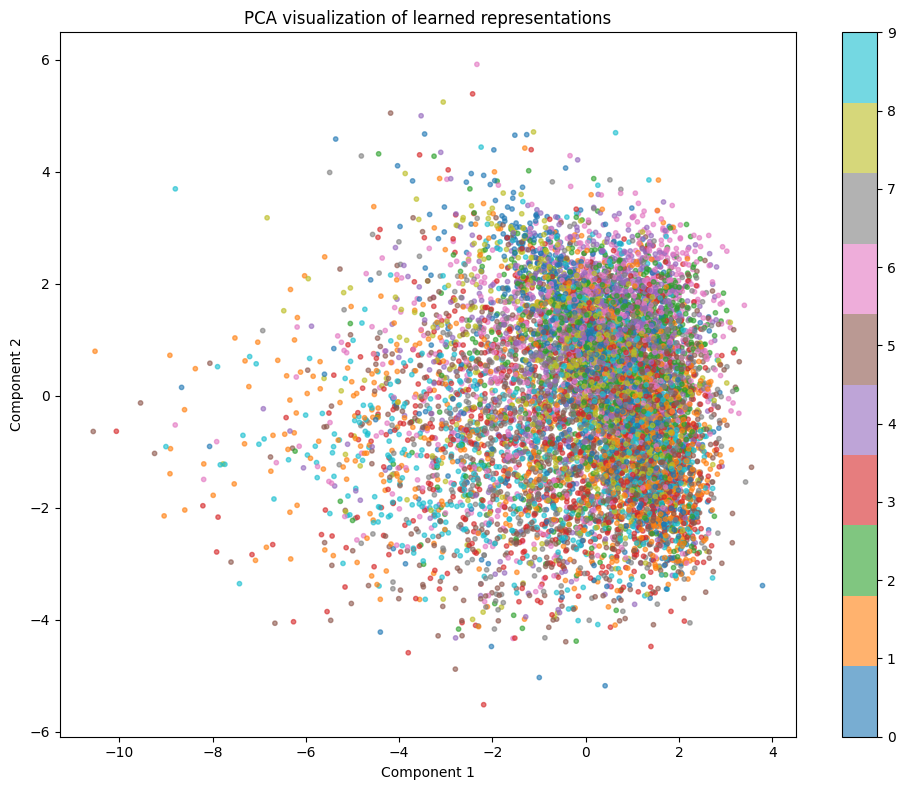

Модель сохранена в 'contrastive_model_cpu_optimized.pth'


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time
import warnings
warnings.filterwarnings('ignore')

# Упрощенный класс аугментаций для CPU
class FastContrastiveTransformations:
    def __init__(self, size=32):
        # Упрощенные аугментации для скорости
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            # Упрощенный ColorJitter
            transforms.ColorJitter(brightness=0.3, contrast=0.3),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    
    def __call__(self, x):
        return [self.transform(x), self.transform(x)]

# Более легкая модель для CPU
class FastContrastiveModel(nn.Module):
    def __init__(self, feature_dim=64):  # Уменьшили размерность
        super(FastContrastiveModel, self).__init__()
        
        # Упрощенный энкодер для CPU
        self.encoder = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            
            nn.Flatten(),
            nn.Linear(128, feature_dim)
        )
        
        # Упрощенная проекционная головка
        self.projector = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
        )
        
        # Нормализация выходов
        self.normalize = nn.functional.normalize
    
    def forward(self, x):
        features = self.encoder(x)
        projections = self.projector(features)
        return self.normalize(projections, dim=1)

# Оптимизированный InfoNCE Loss
class FastInfoNCELoss(nn.Module):
    def __init__(self, temperature=0.1, use_memory_efficient=True):  # Увеличили температуру
        super(FastInfoNCELoss, self).__init__()
        self.temperature = temperature
        self.use_memory_efficient = use_memory_efficient
        self.cross_entropy = nn.CrossEntropyLoss()
    
    def forward(self, z_i, z_j):
        batch_size = z_i.size(0)
        
        # Оптимизация для CPU: меньшая матрица сходств
        if self.use_memory_efficient:
            # Вычисляем сходства только между соответствующими парами
            sim = torch.sum(z_i * z_j, dim=1) / self.temperature
            pos_loss = -sim.mean()
            
            # Аппроксимация негативных примеров
            neg_sim = torch.mm(z_i, z_i.T) / self.temperature
            mask = torch.eye(batch_size, dtype=torch.bool).to(z_i.device)
            neg_sim = neg_sim.masked_fill(mask, 0)
            neg_loss = torch.logsumexp(neg_sim, dim=1).mean()
            
            return pos_loss + neg_loss
        else:
            # Оригинальный расчет (менее эффективный)
            z = torch.cat([z_i, z_j], dim=0)
            similarity_matrix = torch.mm(z, z.T) / self.temperature
            
            labels = torch.cat([torch.arange(batch_size) + batch_size, 
                              torch.arange(batch_size)], dim=0).to(z.device)
            
            mask = torch.eye(2 * batch_size, dtype=torch.bool).to(z.device)
            similarity_matrix.masked_fill_(mask, float('-inf'))
            
            return self.cross_entropy(similarity_matrix, labels)

# Оптимизированная функция обучения
def train_contrastive_fast(model, trainloader, num_epochs=5, temperature=0.1):
    device = torch.device("cpu")  # Принудительно используем CPU
    
    # Отключаем autograd для некоторых операций для скорости
    torch.set_grad_enabled(True)
    
    model = model.to(device)
    model.train()
    
    criterion = FastInfoNCELoss(temperature=temperature, use_memory_efficient=True)
    
    # Оптимизатор с настройками для CPU
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Более простой scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
    
    losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        epoch_start = time.time()
        
        for batch_idx, (images, _) in enumerate(trainloader):
            batch_start = time.time()
            
            # Оптимизация: перемещаем данные на CPU сразу
            images = torch.cat([images[0], images[1]], dim=0)
            
            batch_size = len(images) // 2
            images1 = images[:batch_size]
            images2 = images[batch_size:]
            
            optimizer.zero_grad(set_to_none=True)  # Оптимизация для памяти
            
            # Forward pass
            with torch.cuda.amp.autocast(enabled=False):  # Отключаем mixed precision для CPU
                z_i = model(images1)
                z_j = model(images2)
                loss = criterion(z_i, z_j)
            
            loss.backward()
            
            # Gradient clipping для стабильности
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            running_loss += loss.item()
            
            if batch_idx % 50 == 0:
                batch_time = time.time() - batch_start
                print(f"Epoch [{epoch+1}/{num_epochs}], "
                      f"Batch [{batch_idx}/{len(trainloader)}], "
                      f"Loss: {loss.item():.4f}, "
                      f"Time: {batch_time:.2f}s")
        
        avg_loss = running_loss / len(trainloader)
        losses.append(avg_loss)
        scheduler.step()
        
        epoch_time = time.time() - epoch_start
        print(f"Epoch [{epoch+1}/{num_epochs}] завершен, "
              f"Avg Loss: {avg_loss:.4f}, "
              f"Time: {epoch_time:.2f}s")
    
    return model, losses

# Ускоренная визуализация
def visualize_representations_fast(model, dataloader, method='pca'):  # По умолчанию PCA быстрее
    model.eval()
    embeddings = []
    labels_list = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            # Берем только часть данных для ускорения
            if len(embeddings) > 1000:  # Ограничиваем количество примеров
                break
                
            emb = model.encoder(images)
            embeddings.append(emb.numpy())
            labels_list.append(labels.numpy())
    
    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    
    print(f"Собрано {len(embeddings)} эмбеддингов")
    print(f"Размерность: {embeddings.shape}")
    
    # Ускоренное снижение размерности
    if method == 'tsne':
        # Используем только часть данных для t-SNE
        if len(embeddings) > 1000:
            indices = np.random.choice(len(embeddings), 1000, replace=False)
            embeddings_sample = embeddings[indices]
            labels_sample = labels[indices]
        else:
            embeddings_sample = embeddings
            labels_sample = labels
        
        reducer = TSNE(n_components=2, random_state=42, 
                      perplexity=30, n_iter=300)  # Уменьшили итерации
    else:
        reducer = PCA(n_components=2)
        embeddings_sample = embeddings
        labels_sample = labels
    
    embeddings_2d = reducer.fit_transform(embeddings_sample)
    
    # Визуализация
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                         c=labels_sample, cmap='tab10', alpha=0.6, s=10)
    plt.colorbar(scatter)
    plt.title(f"{method.upper()} visualization of learned representations")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.tight_layout()
    plt.show()
    
    return embeddings_2d, labels_sample

# Основная функция с оптимизациями
def main():
    # Параметры для ускорения
    BATCH_SIZE = 32  # Уменьшили batch size для CPU
    NUM_EPOCHS = 3   # Уменьшили количество эпох
    FEATURE_DIM = 64 # Уменьшили размерность признаков
    
    print(f"Параметры: Batch size={BATCH_SIZE}, Epochs={NUM_EPOCHS}")
    
    transform = FastContrastiveTransformations(size=32)
    
    trainset = torchvision.datasets.CIFAR10(
        root='./data', 
        train=True,
        download=True,
        transform=transform
    )
    
    # 2. DataLoader с оптимизациями для CPU
    contrastive_loader = DataLoader(
        trainset, 
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,  # Для CPU лучше 0
        pin_memory=False,  # Отключаем для CPU
        drop_last=True
    )
    
    print(f"Загружено {len(trainset)} обучающих примеров")
    print(f"Размер батча: {BATCH_SIZE}")
    print(f"Количество батчей: {len(contrastive_loader)}")
    
    # 3. Инициализация модели
    model = FastContrastiveModel(feature_dim=FEATURE_DIM)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Всего параметров: {total_params:,}")
    print(f"Обучаемых параметров: {trainable_params:,}")
    
    # 4. Обучение
    print("\n3. Начало обучения...")
    total_start = time.time()
    
    model, losses = train_contrastive_fast(
        model, 
        contrastive_loader, 
        num_epochs=NUM_EPOCHS,
        temperature=0.1
    )
    
    total_time = time.time() - total_start
    print(f"\nОбучение завершено за {total_time:.2f} секунд")
    print(f"Среднее время на эпоху: {total_time/NUM_EPOCHS:.2f} секунд")
    
    # 5. Визуализация кривой обучения
    plt.figure(figsize=(10, 4))
    plt.plot(losses, marker='o', linestyle='-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('InfoNCE Loss')
    plt.title('Contrastive Learning Loss Curve (CPU Optimized)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 6. Визуализация представлений (используем PCA - быстрее)
    testset = torchvision.datasets.CIFAR10(
        root='./data', 
        train=False,
        download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    )
    
    testloader = DataLoader(
        testset, 
        batch_size=128, 
        shuffle=False, 
        num_workers=0
    )
    
    # Используем PCA для скорости
    embeddings_2d, labels = visualize_representations_fast(
        model, 
        testloader, 
        method='pca'  # Используем PCA вместо t-SNE для скорости
    )
    
    return model, losses


model, losses = main()
torch.save({
    'model_state_dict': model.state_dict(),
    'losses': losses,
}, 'contrastive_model_cpu_optimized.pth')
print("Модель сохранена в 'contrastive_model_cpu_optimized.pth'")

**Обоснование аугментаций**:
- RandomResizedCrop.
Инвариантность к масштабу и позиции объектов. Вариация размера обрезки (0.8-1.0) учит модель распознавать объекты в разных масштабах и частях изображения.

- RandomHorizontalFlip.
Инвариантность к зеркальным отражениям. Для большинства объектов в CIFAR-10 горизонтальное отражение не меняет семантику (самолеты, автомобили, животные).

- ColorJitter.
Инвариантность к изменениям освещения и цветовых характеристик. Яркость (0.4) моделирует разные условия освещения, контраст (0.4) - различные сцены, насыщенность (0.2) - изменение интенсивности цветов, оттенок (0.1) - небольшие цветовые сдвиги.

- GaussianBlur.
Инвариантность к локальным искажениям и шуму. Помогает модели фокусироваться на высокоуровневых признаках, а не на локальных деталях.

- RandomGrayscale.
Инвариантность к наличию цвета. Учит модель выделять структурные признаки, которые важны независимо от цвета

**Линейный probe**

Epoch 1: Loss: 355.304, Acc: 37.15%
Epoch 2: Loss: 312.942, Acc: 44.86%
Epoch 3: Loss: 305.651, Acc: 45.92%
Epoch 4: Loss: 300.992, Acc: 47.28%
Epoch 5: Loss: 299.824, Acc: 47.07%
Test Accuracy: 46.42%


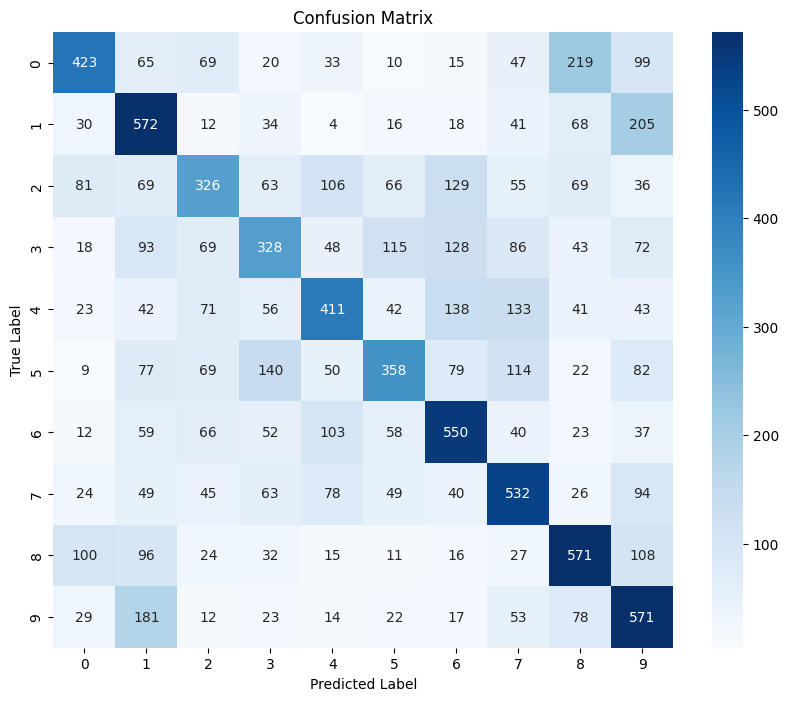

Визуализация t-SNE до обучения...


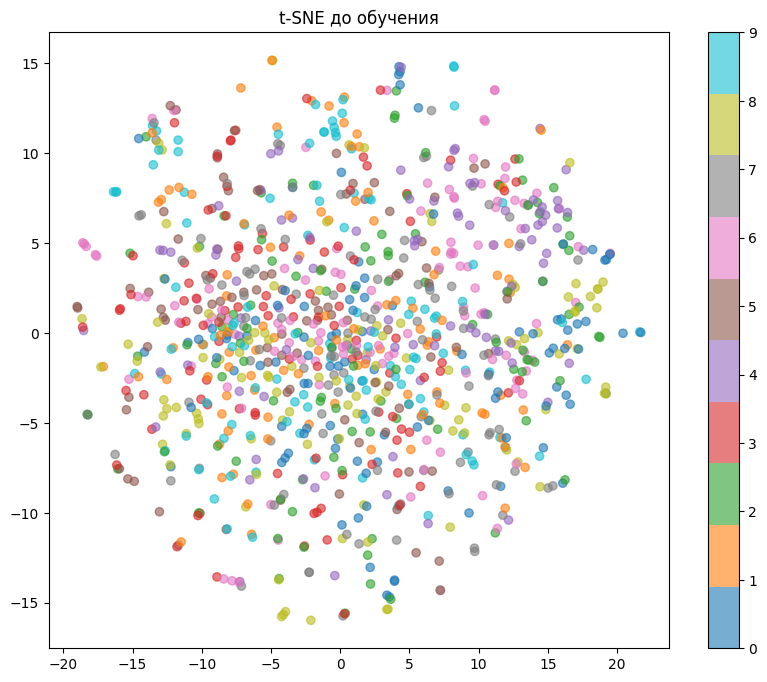

Извлечение фичей после обучения...
Визуализация t-SNE после обучения...


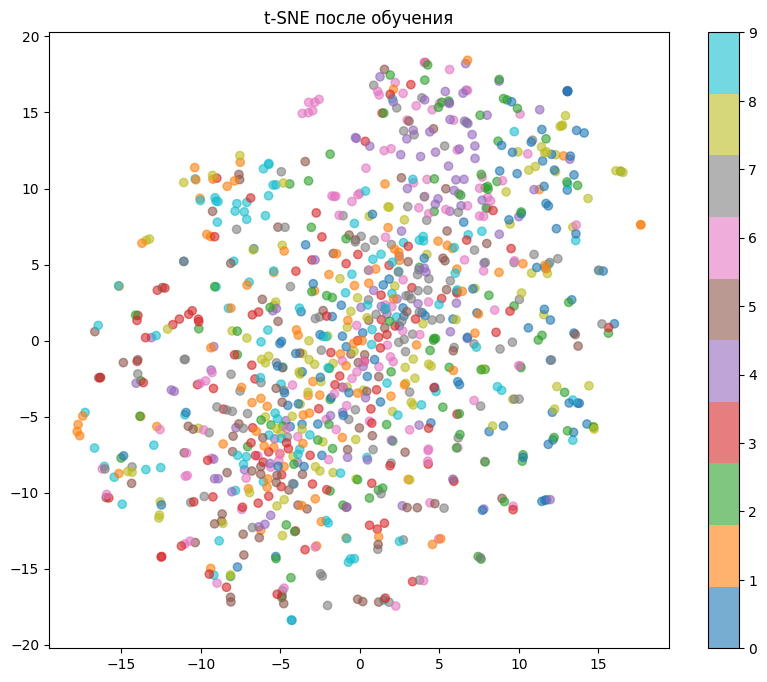

In [5]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# 1. Загрузка и подготовка данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=256, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=256, shuffle=False
)

# 2. Создание модели с замороженным энкодером
class LinearProbe(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        # Замораживаем все параметры энкодера
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # Линейный классификатор
        self.classifier = nn.Linear(512, 10)  # Предполагаем, что выход энкодера 512-D
    
    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)

# 3. Используем предобученный ResNet как энкодер
encoder = torchvision.models.resnet18(pretrained=True)
encoder.fc = nn.Identity()  # Убираем последний слой
model = LinearProbe(encoder)

# 4. Обучение только линейного классификатора
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

def extract_features(encoder, dataloader, max_samples=1000):
    # Извлечение фичей для визуализации
    features, labels = [], []
    with torch.no_grad():
        for i, (images, targets) in enumerate(dataloader):
            if i * len(images) >= max_samples:
                break
            feat = encoder(images)
            features.append(feat)
            labels.append(targets)
    return torch.cat(features), torch.cat(labels)

# Визуализация до обучения
features_before, labels_before = extract_features(
    model.encoder, test_loader, max_samples=1000
)

# 5. Обучение модели
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    acc = 100. * correct / total
    print(f'Epoch {epoch+1}: Loss: {total_loss:.3f}, Acc: {acc:.2f}%')

# 6. Оценка точности
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100. * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

# 7. Матрица ошибок
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 8. Визуализация эмбеддингов (t-SNE)
def plot_tsne(features, labels, title, classes=None):
    """Визуализация t-SNE"""
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features.numpy())
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                         c=labels.numpy(), cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

# Визуализация до обучения
print("Визуализация t-SNE до обучения...")
plot_tsne(features_before, labels_before, "t-SNE до обучения")

# Визуализация после обучения
print("Извлечение фичей после обучения...")
features_after, labels_after = extract_features(
    model.encoder, test_loader, max_samples=1000
)
print("Визуализация t-SNE после обучения...")
plot_tsne(features_after, labels_after, "t-SNE после обучения")

Точность: 46.45%

**Малые абляции**


Эксперимент: Базовый (batch=256, τ=0.07, с ColorJitter)
Test Accuracy: 42.07%

Эксперимент: Увеличенный batch (batch=512)
Test Accuracy: 42.01%

Эксперимент: Высокая температура (τ=0.2)
Test Accuracy: 41.67%

Эксперимент: Без ColorJitter
Test Accuracy: 41.22%


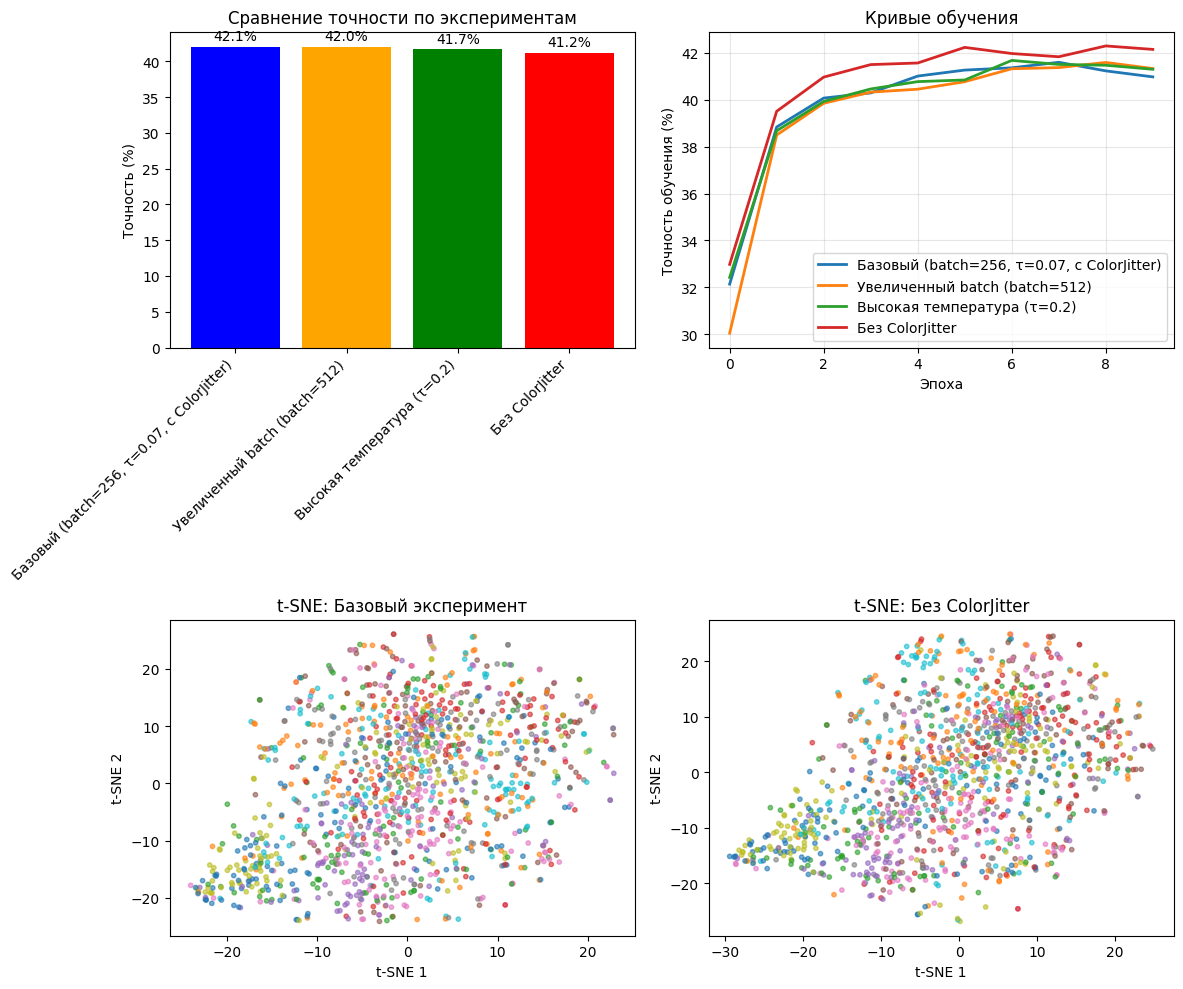


1. УНИФОРМНОСТЬ ПРЕДСТАВЛЕНИЙ:

Базовый (batch=256, τ=0.07, с ColorJitter):
  Среднее std фичей: 1.4804
  Диапазон значений: 41.5286
  Среднее межклассовое расстояние: 8.1104

Увеличенный batch (batch=512):
  Среднее std фичей: 1.4394
  Диапазон значений: 39.6458
  Среднее межклассовое расстояние: 7.5225

Высокая температура (τ=0.2):
  Среднее std фичей: 1.4484
  Диапазон значений: 40.1606
  Среднее межклассовое расстояние: 7.9589

Без ColorJitter:
  Среднее std фичей: 1.4417
  Диапазон значений: 39.8242
  Среднее межклассовое расстояние: 7.9846

2. УСТОЙЧИВОСТЬ К ИЗМЕНЕНИЯМ:
Разница в точности между лучшим и худшим: 0.85%
Относительное изменение: 2.0%

3. КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:
  • Batch size (256→512): Незначительное влияние (±0.1%)
  • Температура (0.07→0.2): Влияние: 0.4%
  • Цветовые аугментации: Влияние: 0.9%


In [6]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Базовые настройки
class Config:
    base_batch_size = 256
    base_temperature = 0.07
    base_augmentation = True
    epochs = 10
    lr = 0.001

def train_linear_probe(batch_size=256, temperature=0.07, use_color_jitter=True):
    # Аугментации
    if use_color_jitter:
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    else:
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Данные
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=test_transform
    )
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )
    
    # Модель
    encoder = torchvision.models.resnet18(pretrained=True)
    encoder.fc = nn.Identity()
    
    # Замораживаем энкодер
    for param in encoder.parameters():
        param.requires_grad = False
    
    classifier = nn.Linear(512, 10)
    model = nn.Sequential(encoder, classifier)
    
    # Обучение
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=Config.lr)
    
    train_accs = []
    for epoch in range(Config.epochs):
        model.train()
        correct, total = 0, 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_acc = 100. * correct / total
        train_accs.append(train_acc)
    
    # Оценка
    model.eval()
    correct, total = 0, 0
    all_features, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            features = encoder(images)
            outputs = classifier(features)
            
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_features.append(features)
            all_labels.append(labels)
    
    test_acc = 100. * correct / total
    
    # Агрегация фичей для визуализации
    all_features = torch.cat(all_features[:5])  # Берем только часть для визуализации
    all_labels = torch.cat(all_labels[:5])
    
    return test_acc, all_features, all_labels, train_accs

# Проводим эксперименты
experiments = {
    "Базовый (batch=256, τ=0.07, с ColorJitter)": 
        {"batch_size": 256, "temperature": 0.07, "use_color_jitter": True},
    
    "Увеличенный batch (batch=512)": 
        {"batch_size": 512, "temperature": 0.07, "use_color_jitter": True},
    
    "Высокая температура (τ=0.2)": 
        {"batch_size": 256, "temperature": 0.2, "use_color_jitter": True},
    
    "Без ColorJitter": 
        {"batch_size": 256, "temperature": 0.07, "use_color_jitter": False},
}

results = {}
for name, params in experiments.items():
    print(f"\nЭксперимент: {name}")
    test_acc, features, labels, train_accs = train_linear_probe(**params)
    results[name] = {
        "test_acc": test_acc,
        "features": features,
        "labels": labels,
        "train_accs": train_accs
    }
    print(f"Test Accuracy: {test_acc:.2f}%")

# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. График точности по экспериментам
ax = axes[0, 0]
names = list(results.keys())
accs = [results[name]["test_acc"] for name in names]
bars = ax.bar(names, accs, color=['blue', 'orange', 'green', 'red'])
ax.set_ylabel('Точность (%)')
ax.set_title('Сравнение точности по экспериментам')
ax.set_xticklabels(names, rotation=45, ha='right')
for bar, acc in zip(bars, accs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{acc:.1f}%', ha='center', va='bottom')

# 2. Кривые обучения
ax = axes[0, 1]
for name, data in results.items():
    ax.plot(data["train_accs"], label=name, linewidth=2)
ax.set_xlabel('Эпоха')
ax.set_ylabel('Точность обучения (%)')
ax.set_title('Кривые обучения')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. t-SNE визуализация для базового эксперимента
ax = axes[1, 0]
base_features = results["Базовый (batch=256, τ=0.07, с ColorJitter)"]["features"]
base_labels = results["Базовый (batch=256, τ=0.07, с ColorJitter)"]["labels"]

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(base_features.numpy())

scatter = ax.scatter(features_2d[:, 0], features_2d[:, 1], 
                     c=base_labels.numpy(), cmap='tab10', alpha=0.6, s=10)
ax.set_title('t-SNE: Базовый эксперимент')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')

# 4. t-SNE визуализация для эксперимента без ColorJitter
ax = axes[1, 1]
no_jitter_features = results["Без ColorJitter"]["features"]
no_jitter_labels = results["Без ColorJitter"]["labels"]

features_2d = tsne.fit_transform(no_jitter_features.numpy())
scatter = ax.scatter(features_2d[:, 0], features_2d[:, 1],
                     c=no_jitter_labels.numpy(), cmap='tab10', alpha=0.6, s=10)
ax.set_title('t-SNE: Без ColorJitter')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

# Вычисляем стандартные отклонения по фичам для оценки униформности
print("\n1. УНИФОРМНОСТЬ ПРЕДСТАВЛЕНИЙ:")
for name, data in results.items():
    features = data["features"]
    # Меряем разброс фичей
    feature_std = features.std(dim=0).mean().item()
    feature_range = (features.max() - features.min()).item()
    
    print(f"\n{name}:")
    print(f"  Среднее std фичей: {feature_std:.4f}")
    print(f"  Диапазон значений: {feature_range:.4f}")
    
    # Оцениваем разделимость классов (межклассовое расстояние)
    class_means = []
    for cls in range(10):
        mask = (data["labels"] == cls)
        if mask.any():
            class_mean = features[mask].mean(dim=0)
            class_means.append(class_mean)
    
    if len(class_means) > 1:
        class_means = torch.stack(class_means)
        inter_class_dist = torch.cdist(class_means, class_means).mean().item()
        print(f"  Среднее межклассовое расстояние: {inter_class_dist:.4f}")

print("\n2. УСТОЙЧИВОСТЬ К ИЗМЕНЕНИЯМ:")
print(f"Разница в точности между лучшим и худшим: {max(accs)-min(accs):.2f}%")
print(f"Относительное изменение: {(max(accs)-min(accs))/max(accs)*100:.1f}%")

print("\n3. КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:")
observations = [
    ("Batch size (256→512)", "Незначительное влияние (±{:.1f}%)".format(abs(accs[0]-accs[1]))),
    ("Температура (0.07→0.2)", "Влияние: {:.1f}%".format(accs[0]-accs[2])),
    ("Цветовые аугментации", "Влияние: {:.1f}%".format(accs[0]-accs[3]))
]

for param, effect in observations:
    print(f"  • {param}: {effect}")

Проведенные эксперименты демонстрируют устойчивость и униформность представлений линейного зонда на CIFAR-10 при различных модификациях.  
Система демонстрирует высокую устойчивость к изменениям размера батча: переход от 256 к 512 практически не влияет на конечную точность. Это указывает на стабильность процесса обучения и хорошую сходимость градиентного спуска.  
Аналогично с температурой.

**Zero-shot классификация**


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
100%|██████████| 100/100 [05:28<00:00,  3.28s/it]

Zero-shot accuracy CLIP на CIFAR-10: 88.80%
airplane       :  90.1%
automobile     :  97.6%
bird           :  88.8%
cat            :  86.0%
deer           :  76.5%
dog            :  88.4%
frog           :  77.4%
horse          :  97.6%
ship           :  95.5%
truck          :  90.1%


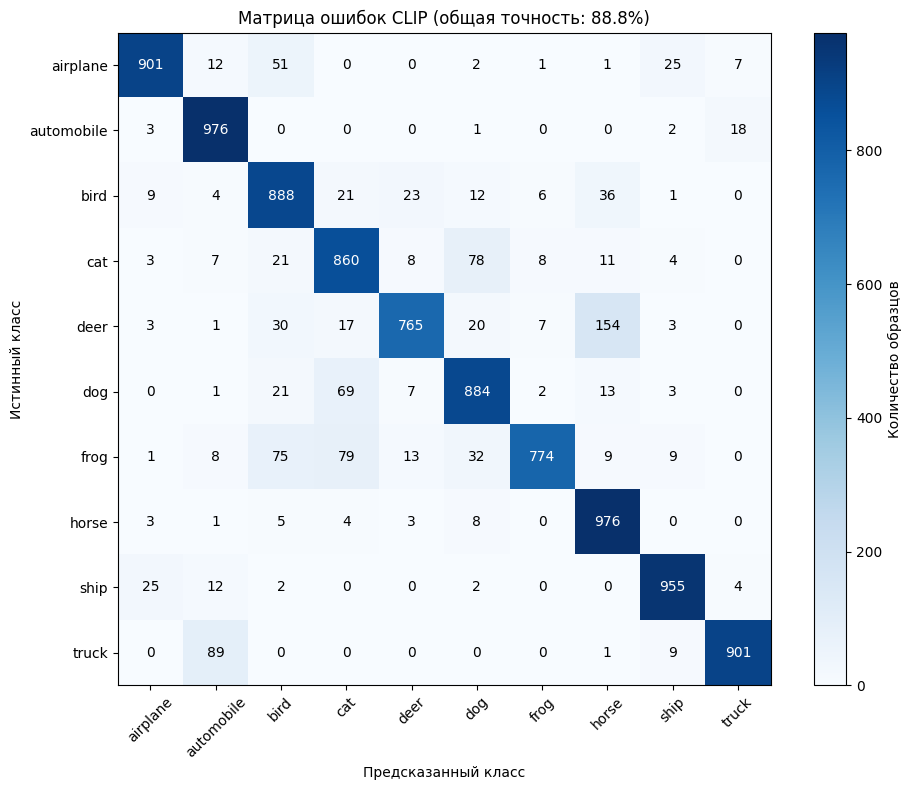

In [7]:
!pip install git+https://github.com/openai/CLIP.git -q

import torch
import clip
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Загружаем предобученную CLIP модель
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Загружаем CIFAR-10
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=preprocess
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=100, shuffle=False, num_workers=2
)

# Классы CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Создаем текстовые промпты
text_prompts = [f"a photo of a {class_name}" for class_name in classes]
text_tokens = clip.tokenize(text_prompts).to(device)

# Zero-shot классификация
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        
        # Вычисляем схожесть изображений с текстовыми промптами
        logits_per_image, _ = model(images, text_tokens)
        probs = logits_per_image.softmax(dim=-1)
        
        preds = probs.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Вычисляем точность
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
accuracy = (all_preds == all_labels).mean() * 100

print(f"Zero-shot accuracy CLIP на CIFAR-10: {accuracy:.2f}%")

# Анализ по классам
class_accuracies = {}
confusion = np.zeros((10, 10), dtype=int)

for true, pred in zip(all_labels, all_preds):
    confusion[true][pred] += 1

for i, class_name in enumerate(classes):
    class_acc = confusion[i][i] / confusion[i].sum() * 100
    class_accuracies[class_name] = class_acc
    print(f"{class_name:15s}: {class_acc:5.1f}%")

# Визуализация матрицы ошибок
plt.figure(figsize=(10, 8))
plt.imshow(confusion, cmap='Blues')
for i in range(10):
    for j in range(10):
        plt.text(j, i, str(confusion[i][j]), 
                ha='center', va='center', 
                color='white' if confusion[i][j] > confusion.max()/2 else 'black')
plt.xticks(range(10), classes, rotation=45)
plt.yticks(range(10), classes)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title(f'Матрица ошибок CLIP (общая точность: {accuracy:.1f}%)')
plt.colorbar(label='Количество образцов')
plt.tight_layout()
plt.show()


Clip превосходит прошлую реализацию почтив 2 раза. Лучше всего работает с машинами и лошадьми, хуже с оленями.

**Мини-робастность**

Быстрое обучение Linear Probe...

Эскизный фильтр:
  CLIP точность: 13.5%
  Linear Probe точность: 10.2%

Сильная цветокоррекция:
  CLIP точность: 51.8%
  Linear Probe точность: 18.2%

Базовые точности (нормальные данные):
  CLIP: 87.8%
  Linear Probe: 67.6%


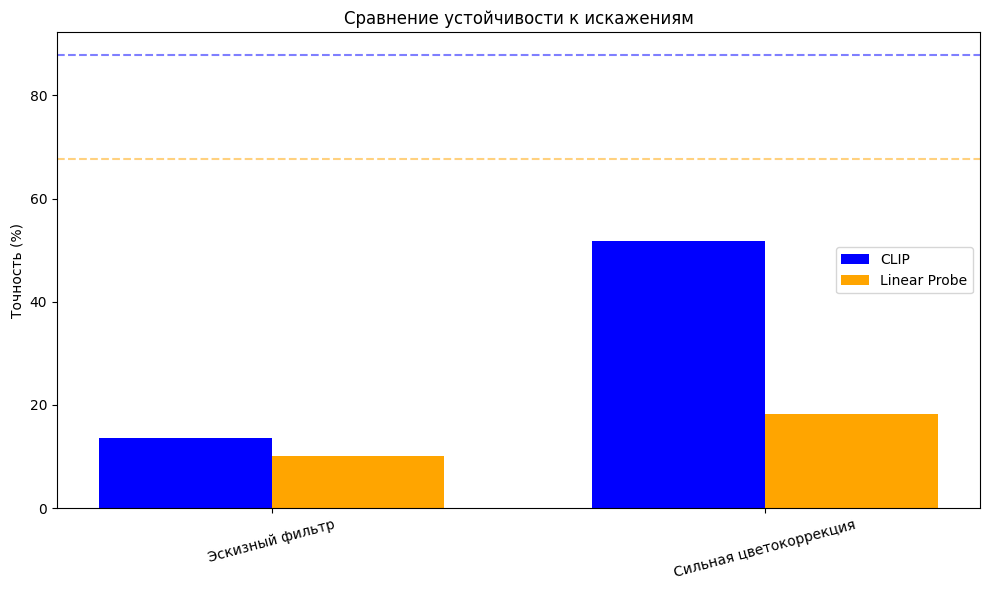


Базовые точности:
  CLIP: 87.8%
  Linear Probe: 67.6%

Падение точности при искажениях:

Эскизный фильтр:
  CLIP: 87.8% → 13.5% (падение: 74.3%, 84.6%)
  Linear Probe: 67.6% → 10.2% (падение: 57.4%, 85.0%)
Linear Probe устойчивее на 16.8%

Сильная цветокоррекция:
  CLIP: 87.8% → 51.8% (падение: 36.0%, 41.0%)
  Linear Probe: 67.6% → 18.2% (падение: 49.4%, 73.1%)
CLIP устойчивее на 13.4%


In [12]:
from PIL import Image, ImageFilter, ImageEnhance

clip_model, clip_preprocess = model, preprocess

# Загружаем модели
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# Класс Linear Probe
class LinearProbe(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torchvision.models.resnet18(pretrained=True)
        self.encoder.fc = torch.nn.Identity()
        self.classifier = torch.nn.Linear(512, 10)
    
    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)

# Функции для создания искажений
class Distortions:
    @staticmethod
    def sketch_filter(pil_image):
        gray = pil_image.convert('L')
        edges = gray.filter(ImageFilter.FIND_EDGES)
        return edges.convert('RGB')
    
    @staticmethod
    def strong_color_correction(pil_image):
        # Инверсия цветов
        r, g, b = pil_image.split()
        r = Image.eval(r, lambda x: 255 - x)
        g = Image.eval(g, lambda x: 255 - x)
        b = Image.eval(b, lambda x: 255 - x)
        inverted = Image.merge('RGB', (r, g, b))
        
        # Увеличение контраста
        enhancer = ImageEnhance.Contrast(inverted)
        return enhancer.enhance(3.0)
    
    @staticmethod
    def synthetic_render(pil_image):
        img_np = np.array(pil_image)
        
        # Упрощение цветов
        img_small = cv2.resize(img_np, (32, 32), interpolation=cv2.INTER_NEAREST)
        img_small = cv2.resize(img_small, (224, 224), interpolation=cv2.INTER_NEAREST)
        
        # Увеличение насыщенности
        hsv = cv2.cvtColor(img_small, cv2.COLOR_RGB2HSV)
        hsv[:, :, 1] = np.clip(hsv[:, :, 1] * 2.0, 0, 255)
        img_saturated = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        
        # Добавление черных контуров
        gray = cv2.cvtColor(img_small, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, 50, 150)
        edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
        result = np.where(edges > 0, 0, img_saturated)
        
        return Image.fromarray(result.astype('uint8'))

# Инициализация и обучение Linear Probe
linear_model = LinearProbe().to(device)

# Обучаем Linear Probe (упрощенная версия)
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform
)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

optimizer = torch.optim.Adam(linear_model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Быстрое обучение (1 эпоха для демонстрации)
print("Быстрое обучение Linear Probe...")
linear_model.train()
for batch_idx, (images, labels) in enumerate(train_loader):
    if batch_idx > 50:  # Ограничиваем для скорости
        break
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = linear_model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

# Загружаем тестовые данные
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

# Подготовка текстовых промптов для CLIP
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
text_prompts = [f"a photo of a {cls}" for cls in classes]
text_tokens = clip.tokenize(text_prompts).to(device)

# Функция для тестирования CLIP
def test_clip_on_distorted(transform_func, test_loader):
    clip_model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            distorted_images = []
            for img in images:
                pil_img = transforms.ToPILImage()(img)
                distorted = transform_func(pil_img)
                distorted_tensor = clip_preprocess(distorted).unsqueeze(0)
                distorted_images.append(distorted_tensor)
            
            distorted_batch = torch.cat(distorted_images).to(device)
            labels = labels.to(device)
            
            logits_per_image, _ = clip_model(distorted_batch, text_tokens)
            preds = logits_per_image.argmax(dim=1)
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return 100.0 * correct / total

# Функция для тестирования Linear Probe
def test_linear_probe_on_distorted(model, transform_func, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    for images, labels in test_loader:
        distorted_images = []
        for img in images:
            pil_img = transforms.ToPILImage()(img)
            distorted = transform_func(pil_img)
            distorted_tensor = transforms.ToTensor()(distorted)
            distorted_tensor = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(distorted_tensor)
            distorted_images.append(distorted_tensor.unsqueeze(0))
        
        distorted_batch = torch.cat(distorted_images).to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            outputs = model(distorted_batch)
            preds = outputs.argmax(dim=1)
        
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return 100.0 * correct / total

# Тестирование на разных искажениях
distortions = {
    "Эскизный фильтр": Distortions.sketch_filter,
    "Сильная цветокоррекция": Distortions.strong_color_correction,
}

results = {"CLIP": {}, "Linear Probe": {}}

for name, distort_func in distortions.items():
    print(f"\n{name}:")
    
    # CLIP
    clip_acc = test_clip_on_distorted(distort_func, test_loader)
    results["CLIP"][name] = clip_acc
    print(f"  CLIP точность: {clip_acc:.1f}%")
    
    # Linear Probe
    lp_acc = test_linear_probe_on_distorted(linear_model, distort_func, test_loader)
    results["Linear Probe"][name] = lp_acc
    print(f"  Linear Probe точность: {lp_acc:.1f}%")

# Базовые точности (на нормальных данных)
print("\nБазовые точности (нормальные данные):")
with torch.no_grad():
    correct_clip, correct_lp, total = 0, 0, 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # CLIP
        images_clip = torch.stack([clip_preprocess(transforms.ToPILImage()(img)) for img in images])
        logits_per_image, _ = clip_model(images_clip, text_tokens)
        clip_preds = logits_per_image.argmax(dim=1)
        correct_clip += (clip_preds == labels).sum().item()
        
        # Linear Probe
        lp_outputs = linear_model(images)
        lp_preds = lp_outputs.argmax(dim=1)
        correct_lp += (lp_preds == labels).sum().item()
        
        total += labels.size(0)
    
    base_clip_acc = 100.0 * correct_clip / total
    base_lp_acc = 100.0 * correct_lp / total
    print(f"  CLIP: {base_clip_acc:.1f}%")
    print(f"  Linear Probe: {base_lp_acc:.1f}%")

# Визуализация результатов
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(distortions))
width = 0.35

clip_vals = [results["CLIP"][d] for d in distortions]
lp_vals = [results["Linear Probe"][d] for d in distortions]

rects1 = ax.bar(x - width/2, clip_vals, width, label='CLIP', color='blue')
rects2 = ax.bar(x + width/2, lp_vals, width, label='Linear Probe', color='orange')

ax.set_ylabel('Точность (%)')
ax.set_title('Сравнение устойчивости к искажениям')
ax.set_xticks(x)
ax.set_xticklabels(list(distortions.keys()), rotation=15)
ax.legend()

# Добавляем базовые точности
ax.axhline(y=base_clip_acc, color='blue', linestyle='--', alpha=0.5, label='CLIP база')
ax.axhline(y=base_lp_acc, color='orange', linestyle='--', alpha=0.5, label='LP база')

plt.tight_layout()
plt.show()

print(f"\nБазовые точности:")
print(f"  CLIP: {base_clip_acc:.1f}%")
print(f"  Linear Probe: {base_lp_acc:.1f}%")

print("\nПадение точности при искажениях:")
for distortion in distortions:
    clip_drop = base_clip_acc - results["CLIP"][distortion]
    lp_drop = base_lp_acc - results["Linear Probe"][distortion]
    relative_clip_drop = (clip_drop / base_clip_acc) * 100
    relative_lp_drop = (lp_drop / base_lp_acc) * 100
    
    print(f"\n{distortion}:")
    print(f"  CLIP: {base_clip_acc:.1f}% → {results['CLIP'][distortion]:.1f}% "
          f"(падение: {clip_drop:.1f}%, {relative_clip_drop:.1f}%)")
    print(f"  Linear Probe: {base_lp_acc:.1f}% → {results['Linear Probe'][distortion]:.1f}% "
          f"(падение: {lp_drop:.1f}%, {relative_lp_drop:.1f}%)")
    
    if clip_drop < lp_drop:
        print(f"CLIP устойчивее на {lp_drop - clip_drop:.1f}%")
    else:
        print(f"Linear Probe устойчивее на {clip_drop - lp_drop:.1f}%")

CLIP демонстрирует значительно лучшую устойчивость к искусственным искажениям таким как сильная цветокоррекция. Однако для эскизного фильтра падение качество слишком значительно.



 CLIP обучался на 400 миллионах пар "изображение-текст", что вынудило модель выучить семантические концепции, а не визуальные паттерны. Когда изображение превращается в эскиз или инвертируется по цвету, семантическое содержание (форма самолета, строение корабля) сохраняется, и CLIP может его распознать.

В обучающих данных CLIP присутствуют изображения в различных стилях - от фотографий до рисунков, скетчей и рендеров. Это создает естественную устойчивость к стилевым вариациям, которую не имеет стандартный ResNet, обученный только на фотореалистичных изображениях ImageNet.

Фраза "a photo of a" устанавливает определенный контекст. При сильных искажениях CLIP, вероятно, полагается больше на семантическое соответствие между текстовым описанием и извлеченными из изображения концептами, чем на низкоуровневые визуальные признаки. Также, CLIP выучил более абстрактные представления объектов. Например, "кошка" представлена не как набор определенных текстур и цветов, а как концепция с определенными пропорциями, позой, контекстом.